In [1]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean, getdf, my_scatter_plot
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import ttest_ind, ttest_rel, chisquare, ks_2samp

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # not really needed

In [5]:
from scipy import stats

# Integer pseudo normal distribution 

In [11]:
scale = 3.
rangex = 10
def get_samp_int(seed, size=30):
    np.random.seed(seed)
    X = truncnorm(a=-rangex/scale, b=+rangex/scale, loc=rangex, scale=scale,).rvs(size=size,random_state=seed)
    X = X.round().astype(int)

    np.random.seed(seed*2)
    Y = truncnorm(a=-rangex/scale, b=+rangex/scale, loc=rangex , scale=scale).rvs(size=size, random_state=seed*2)
    Y = Y.round().astype(int)
    return X, Y
    

In [14]:
X, Y = get_samp_int(10, 1_000_000)

## Verify that it is pseudo normal

(array([   332.,   1550.,   3951.,   8921.,  18220.,  33640.,  54784.,
         80658., 105919., 125314., 132268., 125445., 106524.,  80945.,
         54969.,  33613.,  18302.,   8962.,   3841.,   1507.,    335.]),
 array([ 0.        ,  0.95238095,  1.9047619 ,  2.85714286,  3.80952381,
         4.76190476,  5.71428571,  6.66666667,  7.61904762,  8.57142857,
         9.52380952, 10.47619048, 11.42857143, 12.38095238, 13.33333333,
        14.28571429, 15.23809524, 16.19047619, 17.14285714, 18.0952381 ,
        19.04761905, 20.        ]),
 <a list of 21 Patch objects>)

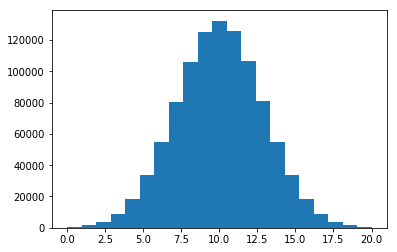

In [15]:
bins = 2 * rangex + 1
plt.hist(X, bins)


In [16]:
def run_test(seed,sample_size, p_dict, sample_func, bins=None):
    #Get samples
    X, Y = sample_func(seed, sample_size)
    
    #Ttest
    p_dict["ttest"].append(ttest_ind(X, Y)[1])
    
    #Exact test
    SGM = significance_of_mean_cuda(bins, dtype_v=np.uint16,dtype_A=np.float64)
    SGM.run(X.reshape(1,-1),Y.reshape(1,-1))
    p_dict["exact"].append(SGM.p_values[0])
        
    return p_val

In [17]:
def get_diff(val1, val2):
    return np.abs(np.array(val1) - np.array(val2))

In [18]:
p_val = dict()
p_val["ttest"], p_val["exact"] = list(), list()
for s in range(100):
    p_val = run_test(s, 150, p_val, get_samp_int, bins=None)

In [19]:
diffs = get_diff(p_val["exact"], p_val["ttest"])

## Let's check how the error is distributed when n_bins is qual to the range of possible sums.

(array([13., 18., 14., 17., 18.,  4.,  1.,  4.,  8.,  3.]),
 array([0.00948835, 0.10663446, 0.20378057, 0.30092667, 0.39807278,
        0.49521889, 0.592365  , 0.68951111, 0.78665722, 0.88380333,
        0.98094944]),
 <a list of 10 Patch objects>)

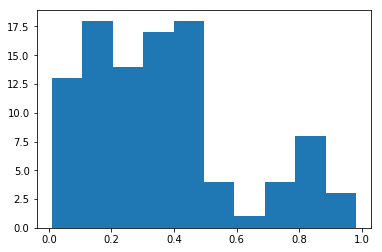

In [20]:
plt.hist(diffs, 10)

In [21]:
np.mean(diffs), np.std(diffs)

(0.3638728864322963, 0.2480433053855093)

# Let's variy the number of bins even though it is integer v

In [22]:
Bin = list()
Diff = list()
for nbins in range(10,180,20):
    p_val = dict()
    p_val["ttest"], p_val["exact"] = list(), list()
    for s in range(1000):
        p_val = run_test(s, 40, p_val, get_samp_int, bins=nbins)
    diffs = get_diff(p_val["exact"], p_val["ttest"])
    Diff.append(diffs)
    Bin.append(nbins)

In [23]:
y = np.asarray(Diff).mean(axis=1)
y_err = np.asarray(Diff).std(axis=1)

Text(0, 0.5, 'Mean error')

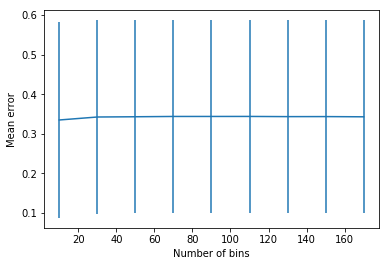

In [24]:
plt.errorbar(Bin,y,y_err)
plt.xlabel("Number of bins")
plt.ylabel("Mean error")

# Normal distribution

In [25]:
def get_samp_cont(seed, size=30):
    np.random.seed(seed)
    X = np.random.normal(0, 1, size)
    Y = np.random.normal(0, 1, size)
    return X, Y

In [26]:
Bin = list()
Diff = list()
for nbins in range(10,180,20):
    p_val = dict()
    p_val["ttest"], p_val["exact"] = list(), list()
    for s in range(1000):
        p_val = run_test(s, 40, p_val, get_samp_cont, bins=nbins)
    diffs = get_diff(p_val["exact"], p_val["ttest"])
    Diff.append(diffs)
    Bin.append(nbins)

In [27]:
y = np.asarray(Diff).mean(axis=1)
y_err = np.asarray(Diff).std(axis=1)

Text(0, 0.5, 'Mean error')

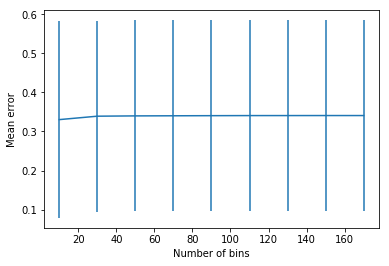

In [28]:
plt.errorbar(Bin,y,y_err)
plt.xlabel("Number of bins")
plt.ylabel("Mean error")